In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This is a new, but powerful library for time series analysis and handling real-world dates
import pandas as pd
import numbers
from scipy.stats import qmc 

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

dt = 1 # Time step [day]

N_runs = 500 # Number of simulations to perform
DD_lower = 1.0  # Lower bound for degree-day factor
DD_upper = 10.5 # Upper bound for degree-day factor
Tt_lower = -1.0 # Lower bound for temperature threshold
Tt_upper = 7.0  # Upper bound for temperature threshold

## 2. Define the Model - Snow 17

New for this time, we will define our model as a function. A function is just a block of code that is a repeated set of calculations we might want to perform over and over again. This allows us to define the function once and call it many, many times. Here is a link where you can learn more about how to create functions. 

In our case, our function is called `Snow17`. It takes as input the time series of mean daily air temperature (in °C) and daily total precipitation (in mm) that are forcings of the model. It also takes as input the value of the degree-day melt factor ($D_D$) and threshold temperature ($T_t$) that will be used as parameter values for a single simulation. The function returns an array of simulated values of SWE, snow melt, and liquid precipitation values. In the code that follows, we will call our function, `Snow17`, with different combinations of parameters. 

Finally, pay attention to the three lines of code that call `assert` 

In [2]:
def Snow17(Ta,P,DD,Tt):
    
    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)
    
    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)
    
    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0 
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
            
        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0
        
        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0
        
        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i
        
        
    return SWE_s17, Sm_s17, Pliq_s17

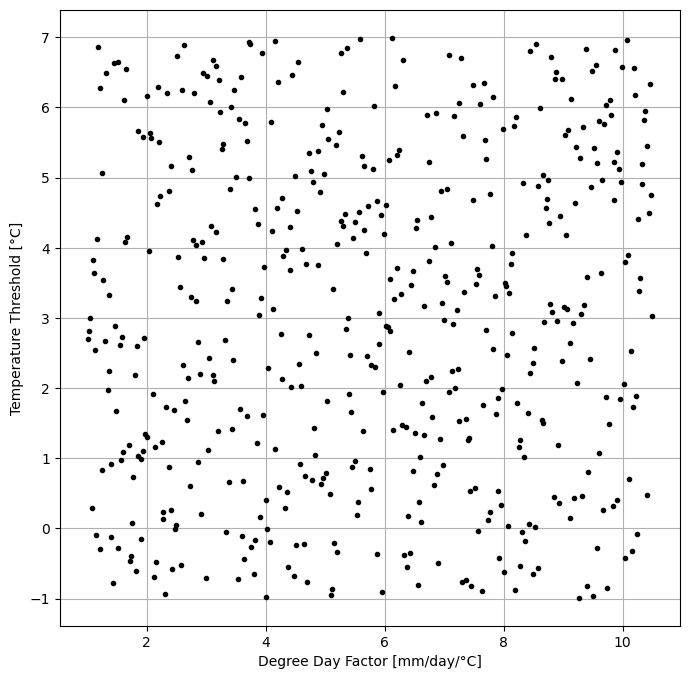

In [3]:
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(N_runs)

l_bounds = [DD_lower, Tt_lower]
u_bounds = [DD_upper, Tt_upper]

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

In [4]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


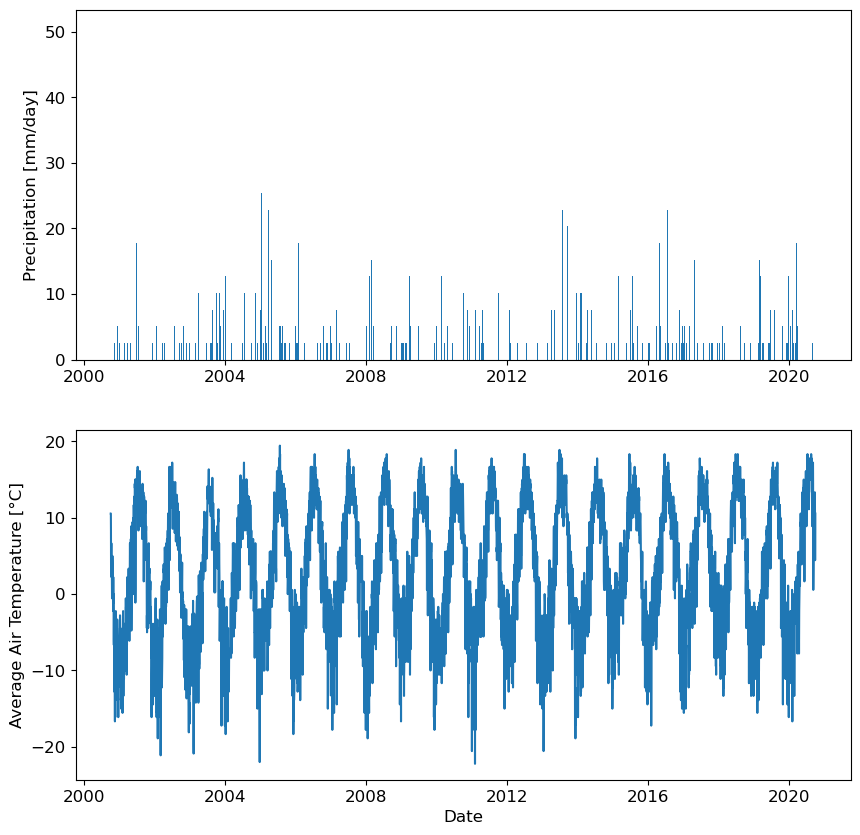

In [5]:
# Plot temperature and precipitation during the period
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(df_forcing['Date'][date_beg:date_end].values,df_forcing['pcp'][date_beg:date_end].values)
plt.ylabel('Precipitation [mm/day]')
plt.subplot(2,1,2)
plt.plot(df_forcing['Date'][date_beg:date_end].values,df_forcing['tair'][date_beg:date_end].values)
plt.xlabel('Date')
plt.ylabel('Average Air Temperature [°C]')
plt.show()

In [6]:
ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values

In [7]:
t = pd.date_range(start=date_beg, end=date_end, freq='1D')
Nt = t.size

SWE_exp = np.zeros((Nt,N_runs))
Sm_exp = np.zeros((Nt,N_runs))
Pliq_exp = np.zeros((Nt,N_runs))

In [8]:
for r in np.arange(N_runs):

    SWE_rep = np.zeros((Nt))
    Sm_rep = np.zeros((Nt))
    Pliq_rep = np.zeros((Nt))
    
    DD_r = sample_scaled[r,0]
    Tt_r = sample_scaled[r,1]
    
    SWE_rep, Sm_rep, Pliq_rep = Snow17(Ta_exp,P_exp,DD_r,Tt_r)
    
    SWE_exp[:,r] = SWE_rep
    Sm_exp[:,r] = Sm_rep
    Pliq_exp[:,r] = Pliq_rep

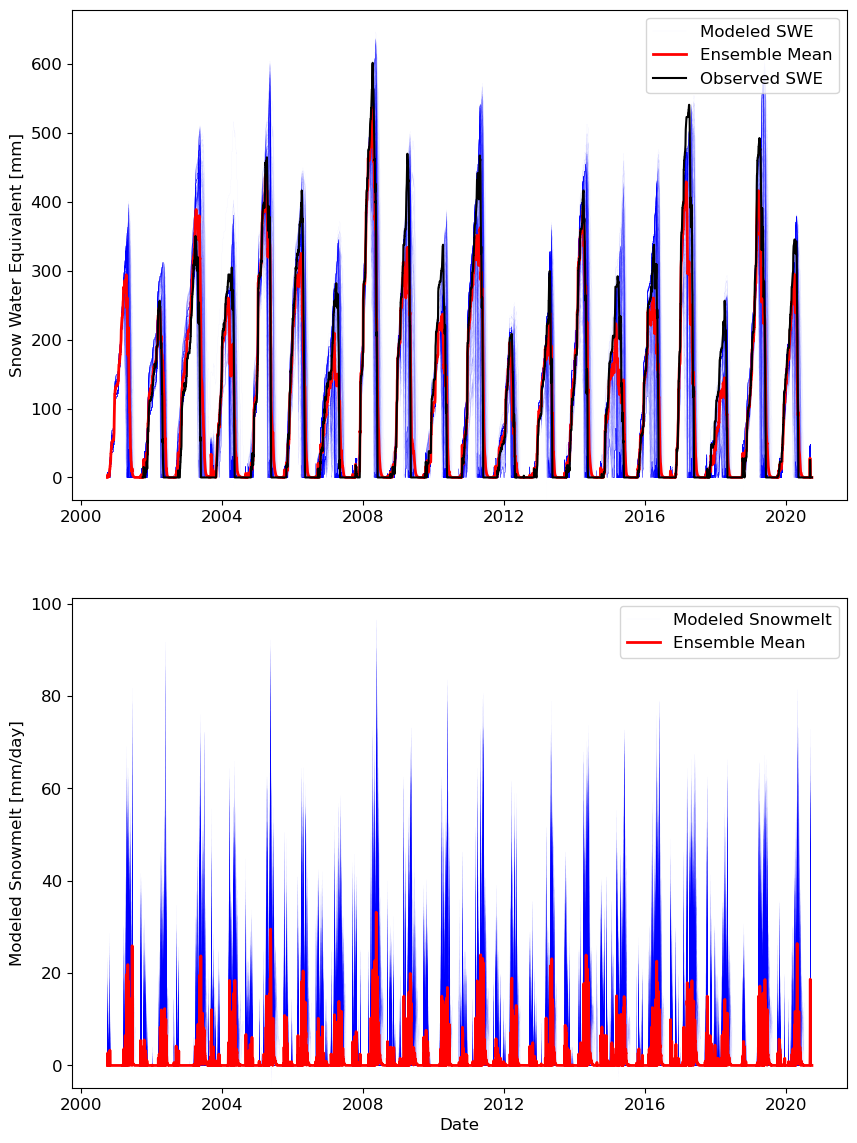

In [9]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,14))

for r in np.arange(N_runs):
    plt.subplot(2,1,1)
    if r == 0:
        plt.plot(t,SWE_exp[:,r],'b-',label='Modeled SWE', linewidth=0.01)
    else:
        plt.plot(t,SWE_exp[:,r],'b-', linewidth=0.01)
    
    plt.subplot(2,1,2)
    if r == 0:
        plt.plot(t,Sm_exp[:,r],'b-',label='Modeled Snowmelt', linewidth=0.01)
    else:
        plt.plot(t,Sm_exp[:,r],'b-', linewidth=0.01)

plt.subplot(2,1,1)
plt.plot(t,np.mean(SWE_exp,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.plot(t,df_forcing[date_beg:date_end]['SWE'].values,'k-',label='Observed SWE')
plt.ylabel('Snow Water Equivalent [mm]')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot(t,np.mean(Sm_exp,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.xlabel('Date')
plt.ylabel('Modeled Snowmelt [mm/day]')
plt.legend(loc='upper right')
plt.show()


## Compute Error Metrics

Now we will compute a variety of individual and compound error metrics to assess the performance of our Snow-17 simulations. We will compute each metric for all combinations of parameters that we considered. We will then map how the value of each error metric varies with the value of the parameters. This will be done via contour maps of the value of the error metric in the parameter space. What we're looking to assess is whether there is a seemingly small area of parameter values that are associated with ideal values of our error metrics, or whether it's more complicated than that? The error metrics we are discussing are commonly used as __objective functions__ that we seek to minimize (like Root Mean Squared Error, RMSE) or maximize (like the Kling Gupta Efficiency, KGE). 

Specifically, as you review the plots below, think about the following questions for each error metric as an objective function:

* How would you describe the shape of the objective function? Is it like a 2-D parabola? A saddle function? A hyperbola? Etc. 
* What does the shape of the objective function in our parameter space imply about whether an "optimal" or close to optimal set of parameters exists? Does only a small range of parameters minimize/maximize the objective function? Or is there a wide space? 
* If there is a really wide space of parameters that minimize/maximize the objective function, what does this imply about the model? Is this good or problematic? If it's problematic, how would we address the problematic nature.  

### Root Mean Squared Error (RMSE)

Recall that the root mean squared error (RMSE) is defined as:

$$
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_{m,i} - y_{o,i})^2}
$$

where $N$ is the number of simulation points (number of days in our simulation in this case), $y_{m,i}$ is the model-predicted SWE on day $i$ and $y_{o,i}$ is the observed SWE on day $i$. The ideal value of RMSE is 0, which would indicate a perfect simulation.  

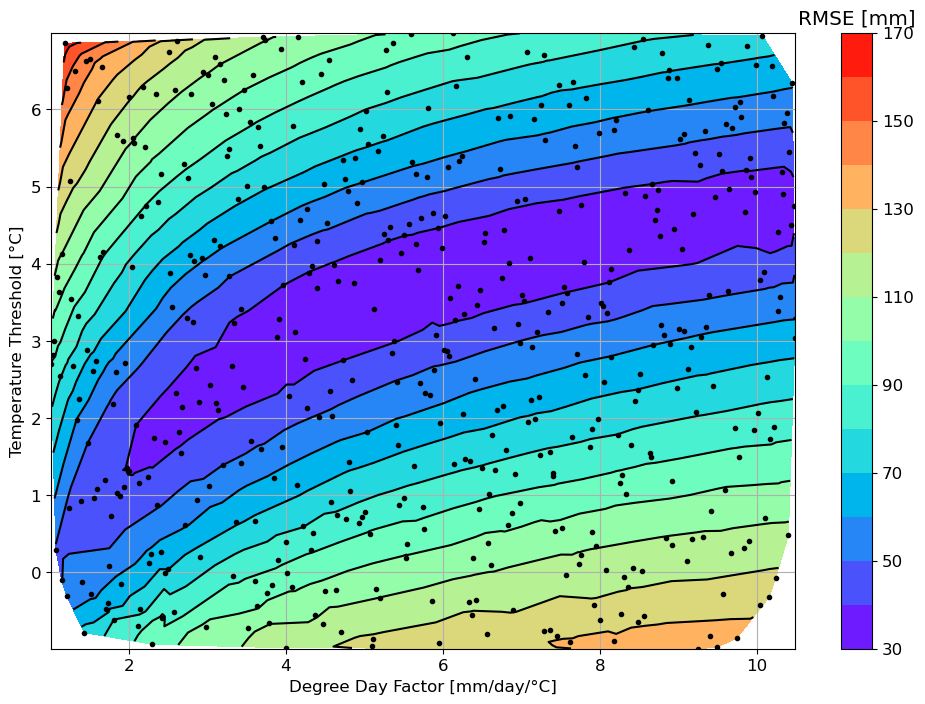

In [15]:
RMSE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    RMSE[r] = np.sqrt(np.nanmean((SWE_exp[:,r] - SWE_o)**2))
    
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(RMSE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(RMSE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('RMSE [mm]')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### MAE

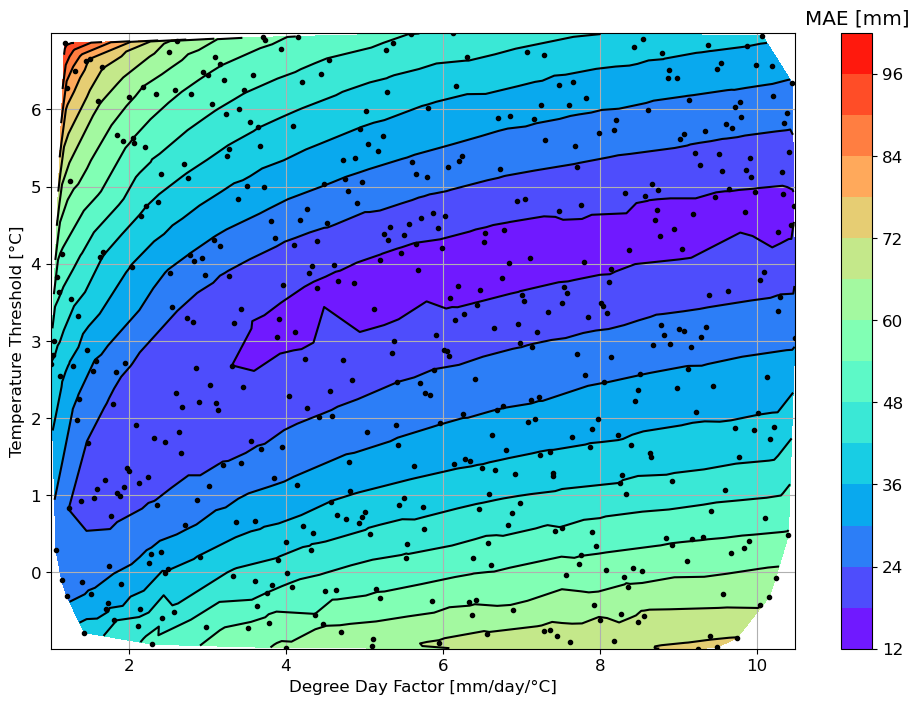

In [16]:
MAE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    MAE[r] = np.nanmean(np.abs(SWE_exp[:,r] - SWE_o))
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(MAE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(MAE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('MAE [mm]')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### Correlation

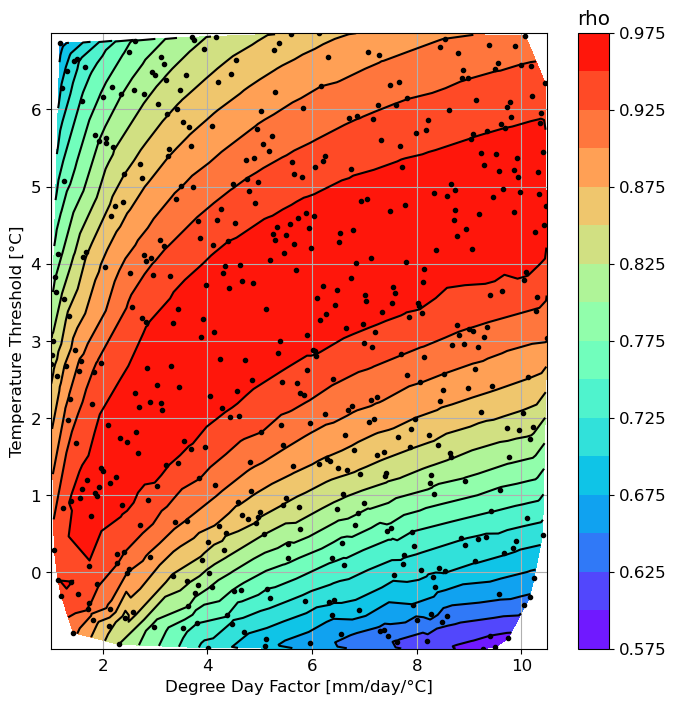

In [12]:
Rho = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    df_swe = pd.DataFrame({'SWE_m': SWE_exp[:,r], 'SWE_o': SWE_o})
    Rho_mat = df_swe.corr().values
    Rho[r] = Rho_mat[1,0]
    
plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(Rho),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(Rho),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('rho')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### KGE

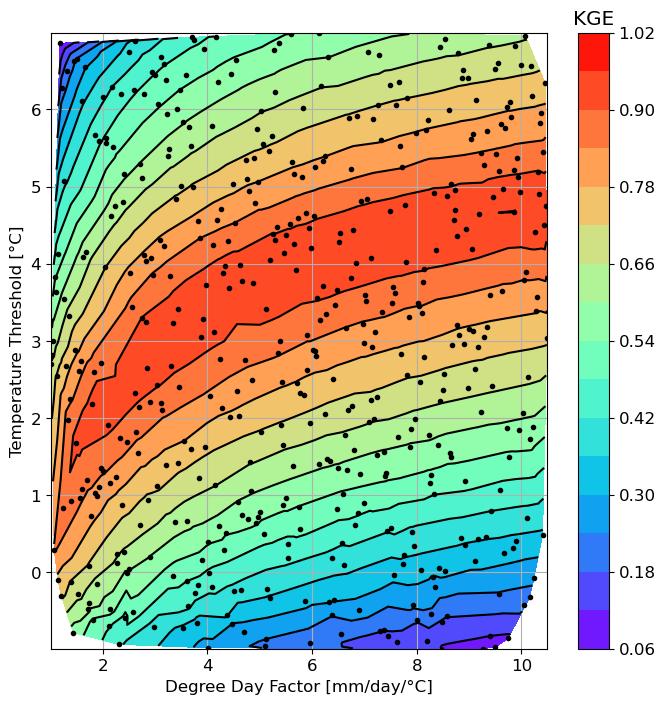

In [13]:
KGE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    # Correlation coefficient
    df_swe = pd.DataFrame({'SWE_m': SWE_exp[:,r], 'SWE_o': SWE_o})
    Rho_mat = df_swe.corr().values
    Rho = Rho_mat[1,0]
    
    # Normalized mean
    beta = np.nanmean(SWE_exp[:,r]) / np.nanmean(SWE_o)
    
    # Normalized standard deviation
    alpha = np.nanstd(SWE_exp[:,r]) / np.nanstd(SWE_o)
    
    # Compute Kling-Gupta Efficiency
    KGE[r] = 1 - np.sqrt((Rho - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(KGE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(KGE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('KGE')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### NSE


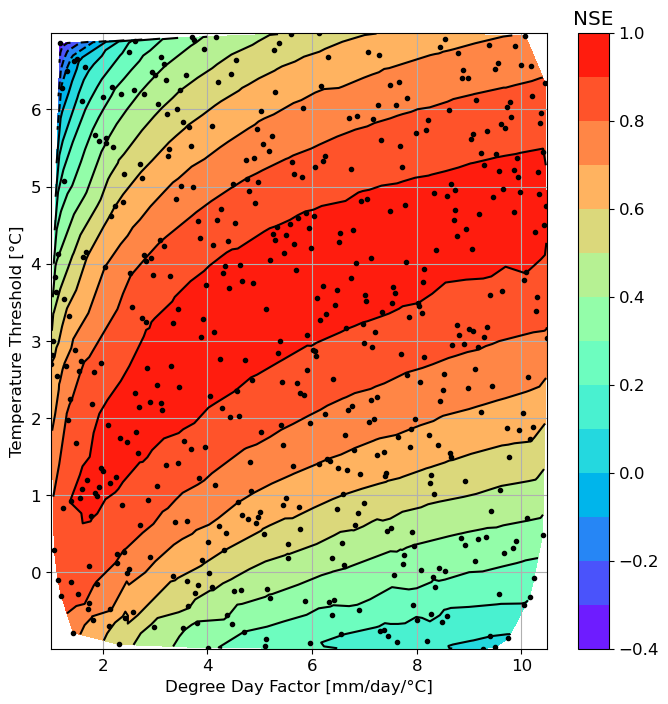

In [14]:
NSE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    NSE[r] = 1 - (np.nansum((SWE_o - SWE_exp[:,r])**2) / np.nansum((SWE_o - np.nanmean(SWE_o))**2))
    
plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(NSE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(NSE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('NSE')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    